## 4.5　自動特徴量選択

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel

### 4.5.1　単変量統計

In [2]:
cancer = load_breast_cancer()
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
X_w_noise = np.hstack([cancer.data, noise])
print(cancer.data.shape)
print(X_w_noise.shape)

(569, 30)
(569, 80)


`percentile` で 50 % の特徴量を選択する。

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print('X_train.shape: {}'.format(X_train.shape))
print('X_train_selected.shape: {}'.format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False]


Text(0.5, 0, 'Sample index')

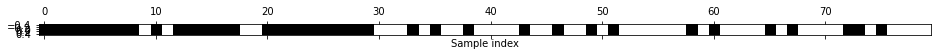

In [4]:
mask = select.get_support()
print(mask[:20])
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')

In [5]:
X_test_selected = select.transform(X_test)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
print('Score with all features: {:.3f}'.format(lr.score(X_test, y_test)))

Score with all features: 0.930


In [6]:
lr.fit(X_train_selected, y_train)
print('Score with only selected features: {:.3f}'.format(lr.score(X_test_selected, y_test)))

Score with only selected features: 0.940


### 4.5.2　モデルベース特徴量選択

In [7]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train.shape: {}'.format(X_train.shape))
print('X_train_l1.shape: {}'.format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Text(0.5, 0, 'Sample index')

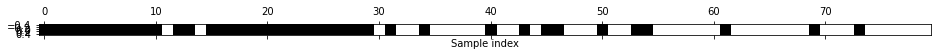

In [8]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')

In [9]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(solver='liblinear').fit(X_train_l1, y_train).score(X_test_l1, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.951


### 4.5.3　反復特徴量選択

Text(0.5, 0, 'Sample index')

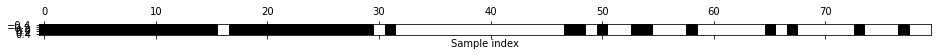

In [10]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)
select.fit(X_train, y_train)
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')

In [11]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)
score = LogisticRegression(solver='liblinear').fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.951


### 参考文献

・[Logistic回帰～cancer～Pythonではじめる機械学習より](http://taustation.com/logistic-regression-cancer-oreilly2335/)